In [50]:
from src import *

@dataclasses.dataclass
class Analysis(Base):
    nodes_tbl : str
        
    def __post_init__(self):
        self.results_stem = self.nodes_tbl.split('.')[-1][6:]
        self.abbr, self.yr, self.level, self.district_type = self.results_stem.split('_')
        self.results_bq = f'{root_bq}.{self.results_stem}'
        self.tbl = f'{self.results_bq}.{self.results_stem}_0000000_allresults'
        delete_table(self.tbl)
#         ot_path / f'results/{self.results_stem}/{self.results_stem}_0000000_allresults.parquet'


    def compute_results(self):
        self.tbls = {'plans':list(), 'stats':list(), 'summaries':list()}
        for src_tbl in bqclient.list_tables(self.results_bq, max_results=1000):
            key = src_tbl.table_id.split('_')[-1]
            self.tbls[key].append(src_tbl.full_table_id.replace(':', '.'))
        
        u = "\nunion all\n"
        stack = {key: u.join([f'select * from {tbl}' for tbl in tbl_list[100:]]) for key, tbl_list in self.tbls.items()}
        
#         cols = [c for c in get_cols(self.nodes) if c not in Levels + District_types + ['geoid', 'county', 'total_pop', 'polygon', 'aland', 'perim', 'polsby_popper', 'density', 'point']]
        cols = [c for c in ['total_white', 'total_black', 'total_native', 'total_asian', 'total_pacific', 'total_other'] if c not in Levels + District_types + ['geoid', 'county', 'total_pop', 'polygon', 'aland', 'perim', 'polsby_popper', 'density', 'point']]

        query = f"""
select
    B.seed,
    B.plan,
    C.{self.district_type},
    max(B.hash) as hash_plan,
    max(B.pop_imbalance) as pop_imbalance_plan,
    max(B.polsby_popper) as polsby_popper_plan,
    max(C.polsby_popper) as polsby_popper_district,
    max(C.aland) as aland,
    max(C.total_pop) as total_pop,
    max(C.total_pop) / sum(E.aland) as density,
    {join_str(1).join([f'sum(E.{c}) as {c}' for c in cols])}
from (
    select
        *
    from (
        select
            *,
            row_number() over (partition by A.hash order by plan asc, seed asc) as r
        from (
            select
                *
            from (
                {subquery(stack['summaries'], indents=4)}
                )
            where
                pop_imbalance < 10.0
            ) as A
        )
    where r = 1
    ) as B
inner join (
    {subquery(stack['stats'], indents=1)}
    ) as C
on
    B.seed = C.seed and B.plan = C.plan
inner join (
    select
        *
    from (
        {subquery(stack['plans'], indents=2)}
        )
    ) as D
on
    C.seed = D.seed and C.plan = D.plan and C.{self.district_type} = D.{self.district_type}
inner join
    {self.nodes_tbl} as E
on
    D.geoid = E.geoid
group by
    seed, plan, {self.district_type}
order by
    seed, plan, {self.district_type}
"""
        load_table(tbl=self.tbl, query=query)
        
start = time.time()
A = Analysis('cmat-315920.redistricting_data.nodes_TX_2020_cntyvtd_cd')
A.compute_results()
print(time_formatter(time.time() - start))


0hrs 0min 37.07sec


In [51]:
df = read_table(self.tbl)

KeyboardInterrupt: 

In [ ]:
df['hash_plan'].nunique()
# df['pop_imbalance_plan'].max()

In [45]:
X = np.linspace(0,10,100)
Y = [df.query('pop_imbalance_plan < @x')['hash_plan'].nunique() for x in X]

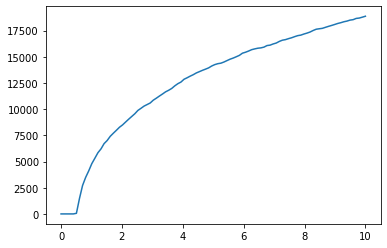

In [46]:
plt.plot(X,Y)

In [24]:
gcs_path  = 'math_for_unbiased_maps_tx'
gcs_bucket = gcsclient.get_bucket(gcs_path)
self=A
bqclient.extract_table(self.tbl, f'gs://{gcs_path}/hi.parquet')

In [26]:
df = pd.read_parquet(root_path/'hi.parquet')
df

OSError: Could not open parquet input source '<Buffer>': Invalid: Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.